In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from matplotlib.colors import Normalize


from utils import *

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 1) Gahuku-Gama

In [3]:
def create_gahuku_gama():

    # read txt containing adjacency matrix
    P = np.loadtxt('data/Gahuku_Gama/Highland_tribes_adjacency_pos.txt')
    N = np.loadtxt('data/Gahuku_Gama/Highland_tribes_adjacency_neg.txt')
    A = P-N

    node_names = np.loadtxt('data/Gahuku_Gama/Highland_tribes_names.txt', dtype = str)
    names_dict = {i:node_names[i] for i in range(len(node_names))}

    # create networkx graph
    G = nx.from_numpy_array(A)
    nx.relabel_nodes(G, names_dict, copy=False)

    return G

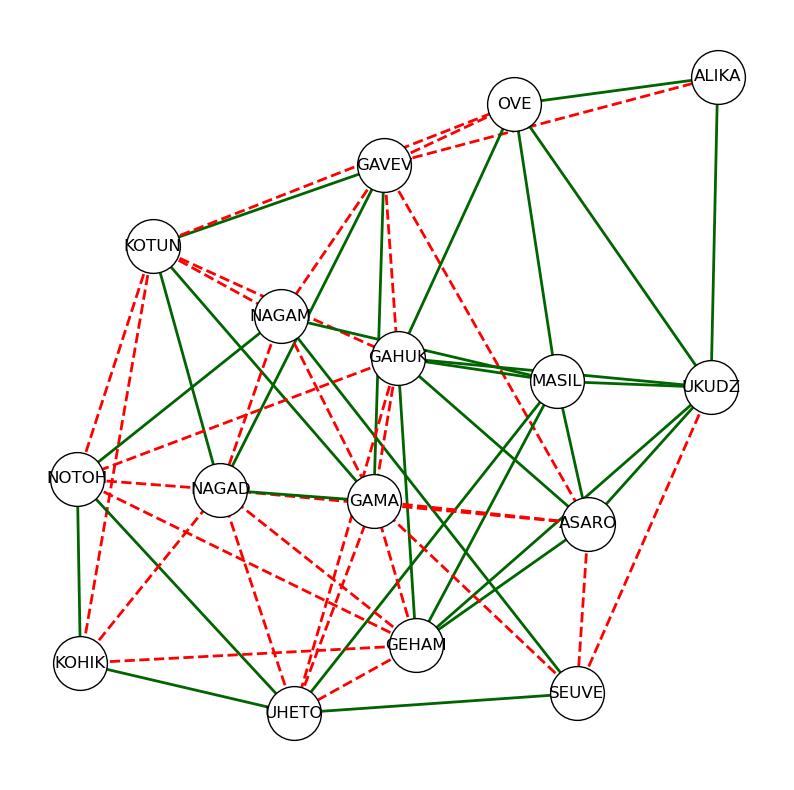

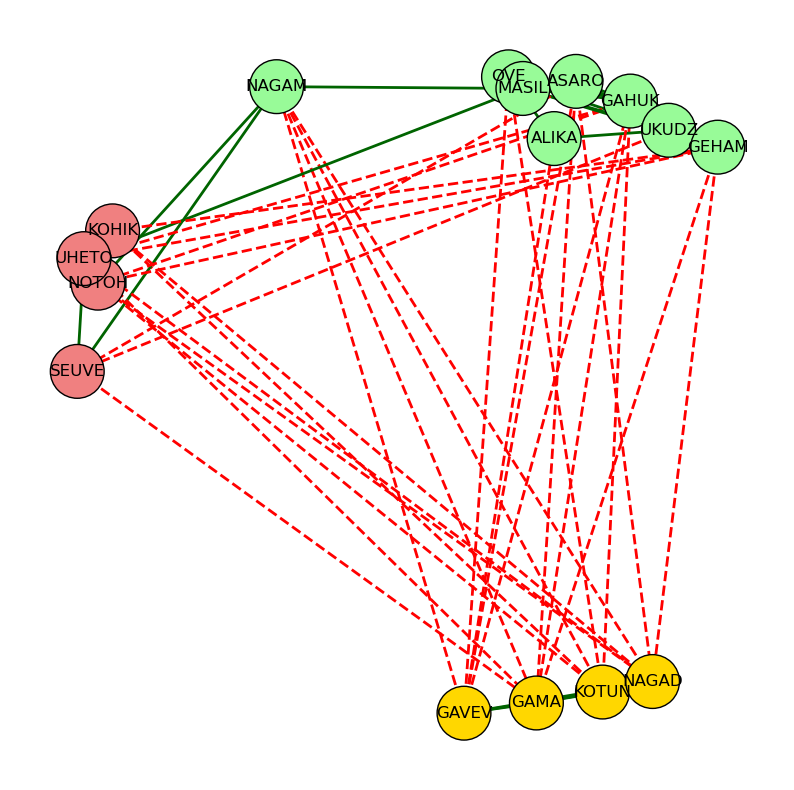

In [4]:
# plot network with standard layout
G = create_gahuku_gama()
node_color = 'white'
ax = draw_network(G, node_color = 'white', node_size = 1500, with_labels = True)

# draw network using communicability embedding, cluster using Kmeans in embedded space
pos = multidimensional_scaling(G, embedding_dimension=2)
labels = compute_clustering(G)
labels_to_colors = {1: 'gold', 0: 'lightcoral', 2: 'palegreen'}
node_color = [labels_to_colors[i] for i in labels]

ax = draw_network(G, pos = pos, node_color = node_color, node_size = 1500, with_labels = True)

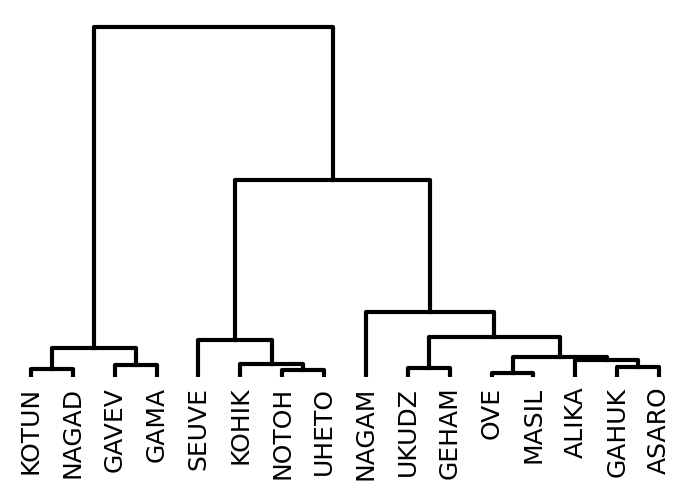

In [7]:
# hierarchical clustering on the embedded space

fig, ax = plt.subplots(1,1, figsize = (7,5))
x_coords = np.array(list(pos.values())).reshape(-1, 2)
Z = linkage(x_coords, method='ward')
dn = dendrogram(Z, ax = ax, labels = list(G.nodes), leaf_rotation=90, leaf_font_size=18, color_threshold = 3)

for i, d in zip(dn['icoord'], dn['dcoord']):
    ax.plot(i, d, color='black', lw = 3) 

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
fig.tight_layout()


# 2) IR networks

In [8]:
def create_IR_network(year):
    
    df = pd.read_csv('data/International_relations/allies_and_enemies_1816_2014_iso.csv')

    df = df[df['year']==year]   # select one particular year
    df = df[(df['alliance'] != 0) | (df['conflict']!=0)]   #filter entries with no link
    
    df['weight'] = df['alliance']+df['conflict']+df['alliance']*df['conflict']   # merge alliances and conflicts in a single column
    df = df.drop(columns = ['alliance','conflict'])
    

    for country in ['SLU','SVG','SKN','SCN', 'SWA']:  #remove countires that aren't in the location dataframe
        df = (df[~(df['statea']==country)])  
        df = (df[~(df['stateb']==country)])
         
    # create the networks
    
    G = nx.from_pandas_edgelist(df, source ='statea', target = 'stateb', edge_attr='weight')
    
    return G


<Axes: >

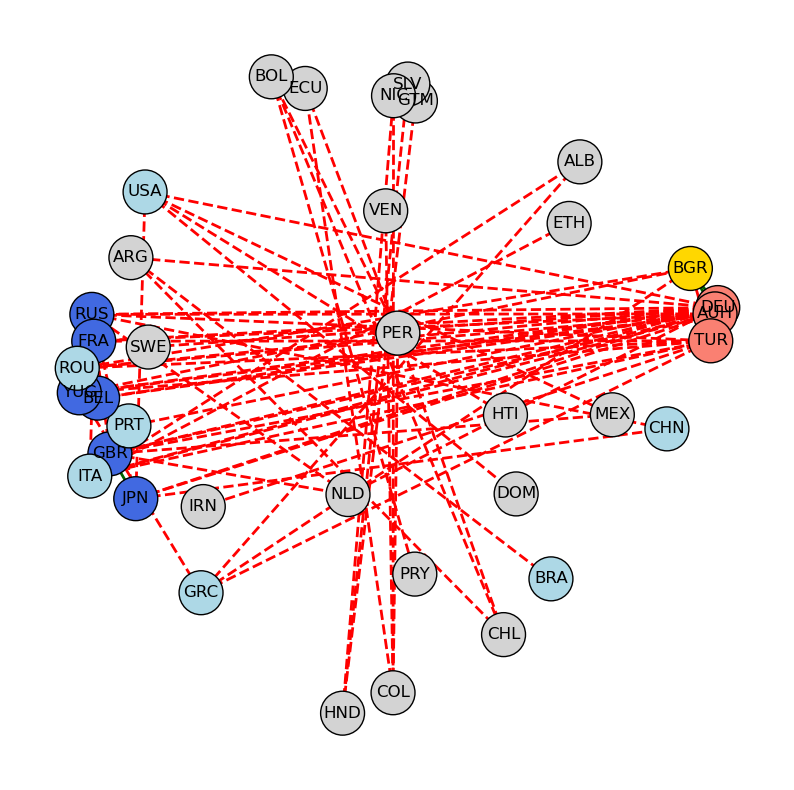

In [11]:
# World War 1
year = 1914
G = create_IR_network(year)
S, xi, theta, X = communicability_metrics(G)

# Ground truth: faction that each country joined
alliances = { 'FRA': 'Entente', 'GBR': 'Entente', 'RUS': 'Entente',  'JPN': 'Entente',
'YUG': 'Entente','BEL': 'Entente','MNG': 'Entente', 'LUX': 'Entente',
'DEU': 'Central Powers', 'AUH': 'Central Powers', 'TUR': 'Central Powers', 'ZAF': 'Central Powers',
'USA': 'FutEnt', 'ITA': 'FutEnt', 'SAU': 'FutEnt','PRT': 'FutEnt','ROU': 'FutEnt','GRC': 'FutEnt','CHN': 'FutEnt','THD': 'FutEnt','BRA': 'FutEnt','CUB': 'FutEnt',
'BGR': 'FutCP'
}


node_colors = ['lightgrey' if node not in alliances.keys() else
               'royalblue' if alliances[node] == 'Entente' else
               'lightblue'  if alliances[node] == 'FutEnt' else
               'gold' if alliances[node] == 'FutCP' else
               'salmon' if alliances[node] == 'Central Powers'  else 'black' for node in G.nodes()]


pos = multidimensional_scaling(G, embedding_dimension=2)
draw_network(G, pos = pos, node_color = node_colors, node_size = 1000, with_labels = True)


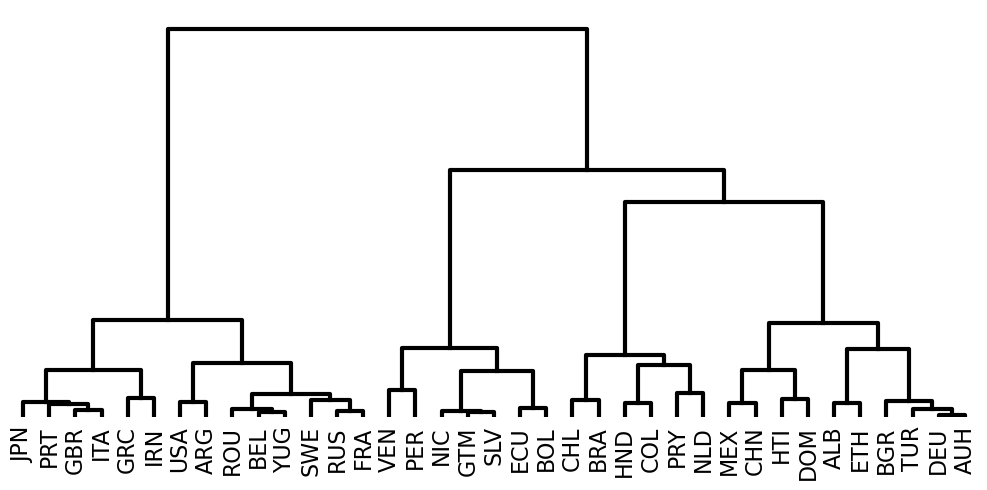

In [12]:
# 2D MDS dendrogram
fig, ax = plt.subplots(1,1, figsize = (10,5))

x_coords = np.array(list(pos.values())).reshape(-1, 2)
linkage_matrix = linkage(x_coords, method='ward')
dn = dendrogram(linkage_matrix, labels=list(pos.keys()), leaf_rotation=90, leaf_font_size=16,
 color_threshold = 4, ax = ax)

country_index = dn['ivl'].index('FRA')+1
country_coord = 5.0*country_index

for i, d in zip(dn['icoord'], dn['dcoord']):    
        ax.plot(i, d, color='black', lw = 3)  

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticks([])
fig.tight_layout()


/tmp/ipykernel_2417348/4239569679.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  alliances = pd.read_csv('data/International_relations/countries_alliances_WW2.txt', index_col = 0, sep = ', ')


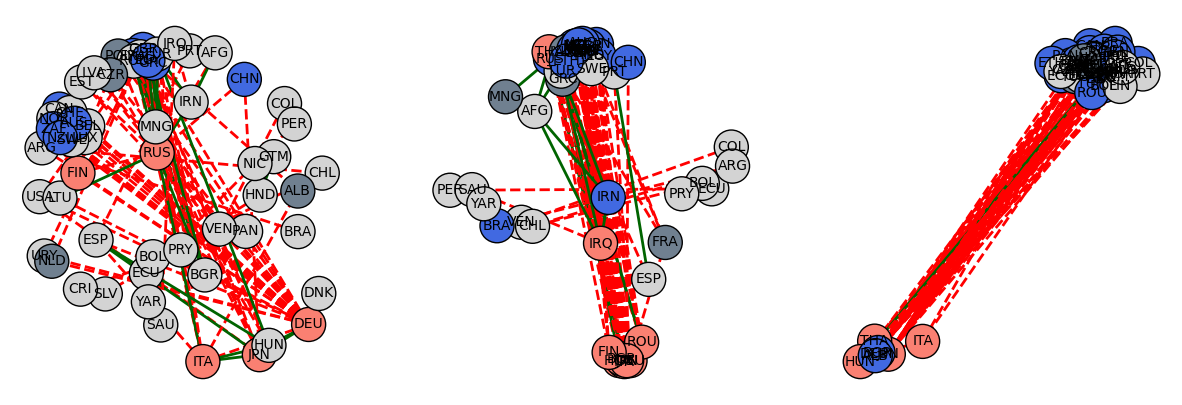

In [21]:
# World War 2
years_v = [1939,1941, 1945]
fig,axs = plt.subplots(1,len(years_v), figsize = (5*len(years_v),5))
alliances = pd.read_csv('data/International_relations/countries_alliances_WW2.txt', index_col = 0, sep = ', ')

for i, year in enumerate(years_v):
    ax = axs[i]
    G = create_IR_network(year)
    alliances_year = alliances[str(year)].to_dict()

    def assign_colors(node):
        if node not in alliances_year.keys():
            color = 'white'
        elif alliances_year[node] == 'Ally':
            color = 'royalblue'
        elif alliances_year[node] == 'Axis':
            color = 'salmon'
        elif alliances_year[node] == 'Occupied':
            color = 'slategrey'
        elif alliances_year[node] == 'Neutral':
            color = 'lightgrey'
        else:
            color = 'pink'
        return color

    node_colors = [assign_colors(node) for node in G.nodes()]
    pos = multidimensional_scaling(G, embedding_dimension=2)

    if year == 1945:     # The 1945 network has an almost perfect factions structure, we include some noise to aid visualization
        pos = {name: (pos_x+0.1*np.random.randn(), pos_y+0.1*np.random.randn()) for (name, (pos_x, pos_y)) in pos.items()}
    draw_network(G, pos = pos, node_color = node_colors, node_size = 600, ax = ax, label_fontsize = 10, with_labels = True)
    

# European Parliament

In [22]:
def create_network_parliament(country, topic, year,  giant_component = True):
    '''
    Creates a networkx Graph object from a csv file containing an edge array with the edge signs
    input:
    filepath: the path to the folder with the adjacency matrix and metadata
    giant_component (default: True): if True, the function returns the giant component of the network. If False, the function returns the entire network.   
    output:
    G: a networkx Graph object'
    '''
     
    path = f'data/European_Parliament/{country}/{topic}/{year}-{year-2000+1}/'

    # Load the adjacency matrix into a Graph object
    adjacency_matrix = np.loadtxt(path+'signed.csv', delimiter=",")
    G = nx.from_numpy_array(adjacency_matrix)

    # Load the metadata into the network nodes
    attributes = pd.read_csv(path+'attributes.csv')
    nx.set_node_attributes(G, attributes.T.to_dict() )

    if giant_component == True:
        Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
        G0 = G.subgraph(Gcc[0])

        # relabel the nodes
        mapping = {old_name: i for i, old_name in enumerate(G0.nodes())}
        G0 = nx.relabel_nodes(G0, mapping)
        return G0

    else:
        return G
    



def quasi_chordplot(G,
                    position_attribute,
                    nodecolor_attribute,
                    nodecolor_dict = None,
                    ax = None,
                    interspace = 5,
                    node_size = 200,
                    node_edgecolor = 'k',
                    positive_edgewidth = .2,
                    negative_edgewidth = .5, 
                    with_labels = False):
                    
    '''draws a quasi-chordplot of the network
    input:
    G: a networkx Graph object
    nodecolor_dict: dictionary that associates a color to each political group
    position_attribute (string):  label of the dictionary of node attributes that will be used to assign node positions
    nodecolor_attribute (string): label of the dictionary of node attributes that will be used to assign node colors
    ax: matplotlib axis object
    interspace: angular space between groups
    node_size: size of the nodes
    node_edgecolor: color of the node edges
    positive_edgewidth: width of the positive edges
    negative_edgewidth: width of the negative edges
    noise: noise added to the node positions to avoid overlapping nodes'''

    if ax == None:
        fig, ax = plt.subplots(figsize = (10, 10))

    if nodecolor_dict == None:
        nodecolor_dict = {'EPP': 'royalblue', 'SD': 'red', 'ALDE': 'gold', 'ECR': 'skyblue', 'EFD': 'blue', 
                         'Greens': 'forestgreen', 'EFA': 'forestgreen', 'NI': 'black', 'GUENGL': 'maroon'} 

    # create directed graph and store only one directed edge (this is because curved edges only work in DiGraphs)
    G = nx.DiGraph(G)
    for (u, v) in G.edges():
        if G.has_edge(u, v):
            G.remove_edge(v, u)
    
    # associate a position to each node such that nodes of the same political group are together
    N = G.order()
    groups = set([G.nodes[i][position_attribute] for i in G.nodes()])
    Neff = N + interspace*len(groups)  # total angular range including spaces between groups
    pos = {}
    counter = 0

    for group in groups:
        nodes_of_group_i = [node_i for node_i, group_i in G.nodes(data=position_attribute) if group_i == group]    # get nodes of one political group
        for node in nodes_of_group_i:
            pos[node] = (np.cos(2*np.pi*counter/Neff), np.sin(2*np.pi*counter/Neff))
            counter += 1
        counter += interspace

    # assign a color to each node, based on the attribute specified in nodecolor_attribute and group_dict
    metadata = dict(G.nodes(data = True))
    node_group = [metadata[i][nodecolor_attribute] for i in G.nodes()]
    node_color = list(map(lambda x: nodecolor_dict[x], node_group))

    # assing a color to each edge, depending on its sign
    edge_color = ['']*G.number_of_edges()
    ls = ['']*G.number_of_edges()
    width = np.zeros(len(ls))
    for i, (u, v, w) in enumerate(G.edges(data = 'weight')):
        edge_color[i] = 'darkgreen' if w>0 else 'red'
        ls[i] = '-' if w>0 else '-'
        width[i] = positive_edgewidth if w>0 else negative_edgewidth

    # draw the network
    nodes = nx.draw_networkx_nodes(G,  pos = pos, ax = ax, node_size = node_size, node_color = node_color)
    nodes.set_edgecolor(node_edgecolor)
    nx.draw_networkx_edges(G, pos = pos, ax = ax,  edge_color = edge_color, style = ls, width = width, connectionstyle = 'arc3,rad=0.2', arrowstyle = '-')
    if with_labels:
        pass
        nx.draw_networkx_labels(G, pos = pos, ax = ax)

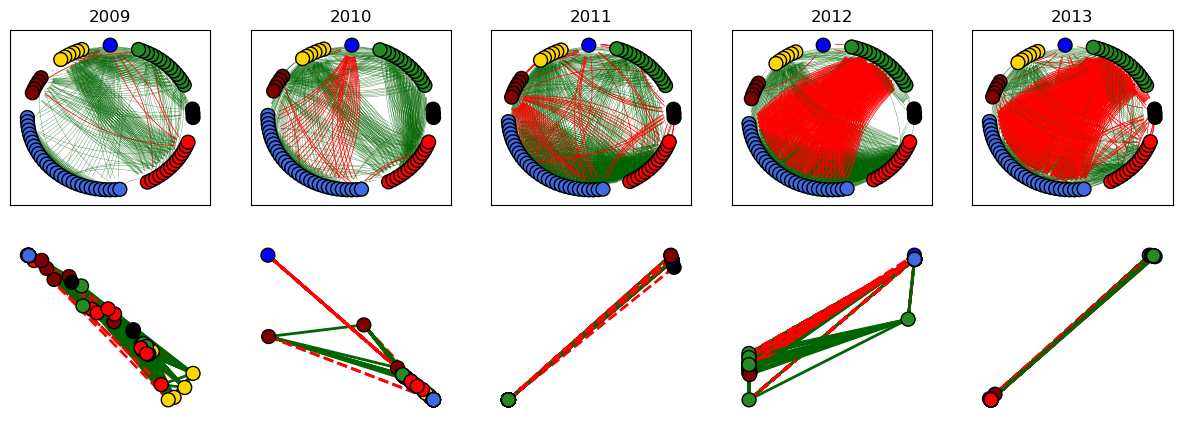

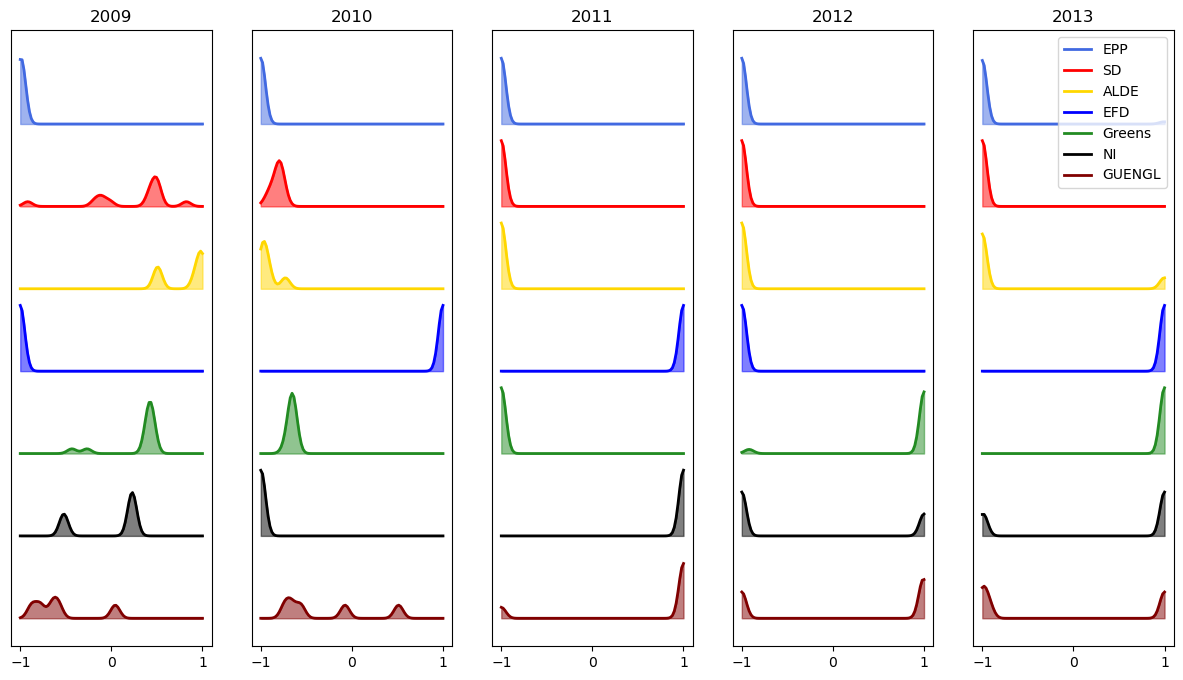

In [27]:
country = 'France'; topic = 'AGRI';
years_v = np.arange(2009,2014)
groups = ['EPP', 'SD', 'ALDE', 'EFD', 'Greens', 'NI', 'GUENGL']

nodecolor_dict = {'EPP': 'royalblue', 'SD': 'red', 'ALDE': 'gold', 'ECR': 'skyblue', 'EFD': 'blue', 
 'Greens': 'forestgreen', 'EFA': 'forestgreen', 'NI': 'black', 'GUENGL': 'maroon'}    

fig, ax = plt.subplots(2,len(years_v), figsize = (15,5))
fig2, ax2 = plt.subplots(1,len(years_v), figsize = (15,8), sharex = True, sharey = True)

for i,year in enumerate(years_v):

    G = create_network_parliament(country, topic, year,  giant_component = True)
    
    # chordplot
    quasi_chordplot(G, 'Group',  'Group', ax = ax[0,i], nodecolor_dict = nodecolor_dict, node_size = 100,)

    # embedding
    node_group = list(nx.get_node_attributes(G, 'Group').values())
    node_color = [nodecolor_dict[j] for j in node_group]
    pos = multidimensional_scaling(G, embedding_dimension=2)

    # plot the embedded network
    draw_network(G, pos = pos, node_color = node_color, node_size = 100, ax = ax[1,i], labels = {})
    ax[0,i].set_title(year)

    # PCA for polarization inference
    pos_array = np.array(list(pos.values())).reshape(-1,2)
    one_dim_embedding = PCA(n_components = 1).fit_transform(pos_array)
    a = np.min(one_dim_embedding); b = np.max(one_dim_embedding)
    one_dim_embedding = 2*(one_dim_embedding-a)/(b-a)-1  # normalize
    X_plot = np.linspace(-1,1,100).reshape(-1,1)

    # histograms
    for j, group in enumerate(groups):
        party_members_ideology = one_dim_embedding[np.array(node_group) == group]
        kde = KernelDensity(kernel='gaussian', bandwidth=0.05).fit(party_members_ideology)
        log_dens = kde.score_samples(X_plot)
        ax2[i].plot( X_plot[:, 0], 0.5*np.exp(log_dens)-5*j, color=nodecolor_dict[group], lw=2, label = group)
        ax2[i].fill_between(X_plot[:, 0], 0.5*np.exp(log_dens)-5*j, -5*j, alpha=0.5, color=nodecolor_dict[group])
        ax2[i].set_title(year)
        ax2[i].set_yticks([])
ax2[-1].legend()
    

# 4) E. Coli

/tmp/ipykernel_2417348/3066725785.py:32: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('coolwarm'),


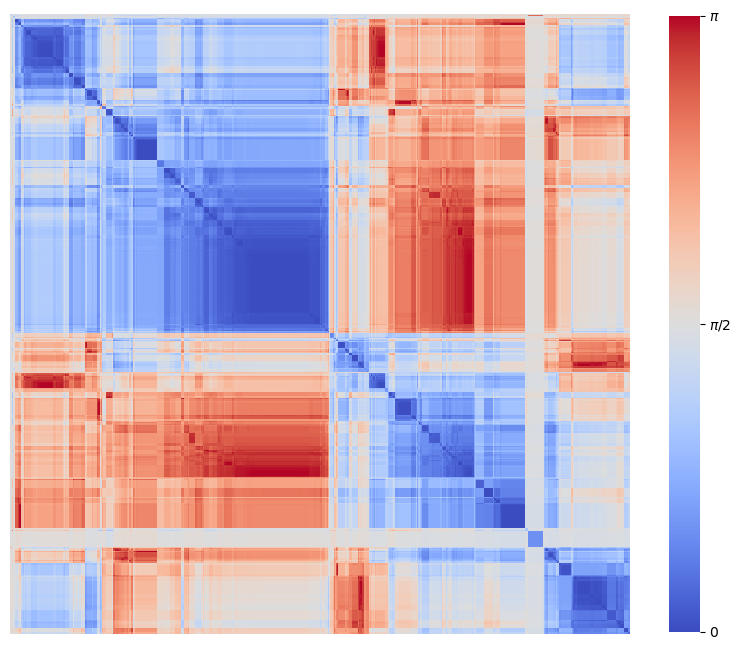

In [24]:
def create_ecoli():

    adj_list = np.loadtxt(f'data/Ecoli/ecoli_symm.txt', dtype = int)
    n = np.max(adj_list)
    adj_matrix = np.zeros((n, n), dtype=int)
    
    # Fill the adjacency matrix
    for (node1, node2, sign) in adj_list:
        adj_matrix[node1-1, node2-1] = sign
        adj_matrix[node2-1, node1-1] = sign

    # extract the largest component
    G = nx.from_numpy_array(adj_matrix)
    Gs_nodes = max(nx.connected_components(G), key=len)
    Gs = G.subgraph(Gs_nodes)
    A = nx.to_numpy_array(Gs)
    
    return A


A = create_ecoli()
theta = communicability_metrics(A, 'angle')
theta = (theta + theta.T) / 2 # correct rounding errors
linkage_matrix = linkage(squareform(theta), method='average')
sorted_indices = leaves_list(linkage_matrix)
sorted_matrix = theta[sorted_indices][:, sorted_indices]

# Plot the heatmap
fig, ax = plt.subplots(1,1,figsize=(10, 10))
bar = sns.heatmap(
    sorted_matrix, 
    cmap=plt.cm.get_cmap('coolwarm'), 
    square=True, 
    cbar=True, 
    cbar_kws={'shrink': 0.8},
    norm=Normalize(vmin=0, vmax=np.pi)  # Normalize between 0 and π
    )
ax.set_xticks([])  # Remove x-ticks
ax.set_yticks([])  # Remove y-ticks

# Adjust the colorbar
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0, np.pi / 2, np.pi])  # Set ticks at 0, π/2, π
colorbar.set_ticklabels(['0', r'$\pi/2$', r'$\pi$'])  # Use Greek symbols


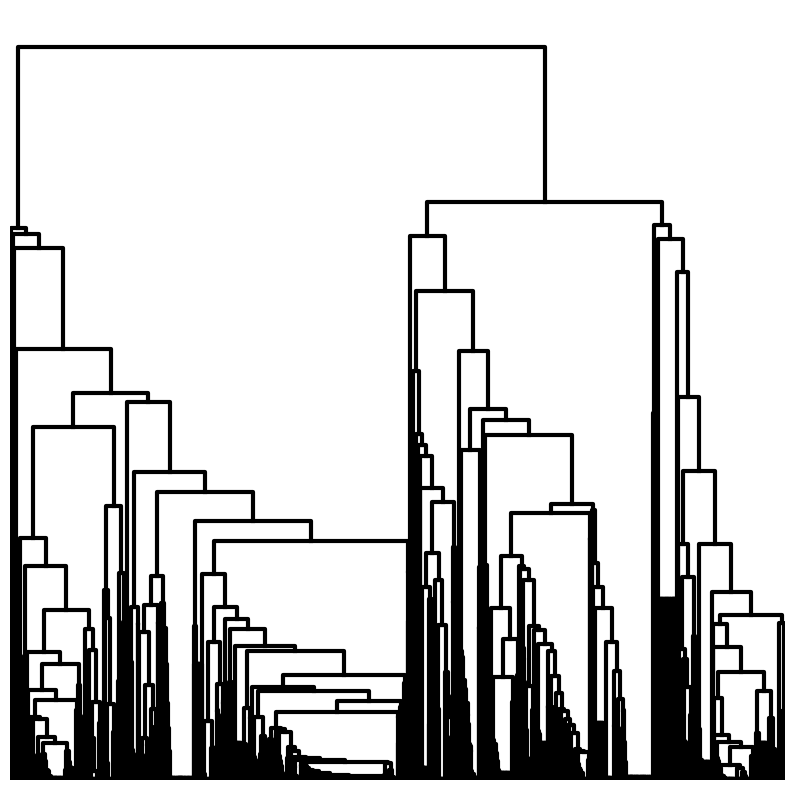

In [25]:
# Dendrogram (without dimensionality reduction)

fig, ax = plt.subplots(1,1,figsize=(10, 10))
linkage_matrix = linkage(squareform(theta), method='average')
dn = dendrogram(linkage_matrix, leaf_rotation=90,ax = ax)
ax.set_yticks([])  # Remove y-ticks
ax.set_xticks([])  # Remove x-ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

for i, d in zip(dn['icoord'], dn['dcoord']):    
    ax.plot(i, d, color='black', lw = 3)  
